In [163]:
from unsupervised_dac import DAC
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from utils import define_contour_init

In [ ]:
filename = "pineapple.jpg"
img = plt.imread(os.path.join("images_test_unsupervised_dac", filename))
shape_origin = img.shape
img = cv2.resize(img, (1024,1024), interpolation = cv2.INTER_AREA)
shape = img.shape[:-1]

In [192]:
####BACKGROUND REMOVAL SETUP:

##### SETUP FOR REAL LIFE IMAGES

# dac = DAC(nb_points = 100,
#           n_epochs = 600,
#           learning_rate = 1e-1,
#           clip = 1e-1,
#           exponential_decay = 0.999,
#           thresh = 1e-2,
#           weights = [1,1,1,1,1],
#           frame_force = 0.
#           )

##### BACKGROUND REMOVAL SETUP FOR HISTOLOGY IMAGES

# dac = DAC(nb_points = 100,
#           n_epochs =300,
#           learning_rate = 1.,
#           clip = 1e-2,
#           exponential_decay = 0.995,
#           thresh = 1e-4,
#           weights = [1,1/2,1/4,1/8,1/16],
#           frame_force = 1e-2,
#           )


####UNSUPERVISED SEGMENTATION SETUP:

##### SETUP FOR REAL LIFE IMAGES

dac = DAC(nb_points = 100,
          n_epochs = 70,
          learning_rate = 9e-3,
          clip = 1.,
          exponential_decay = 0.999,
          thresh = 1e-2,
          weights = [1,1/2,1/4,1/8,1/16],
          area_force = 0.,
          gaussian_sigma=1e-4
          )


##### UNSUPERVISED SEGMENTATION SETUP

##### SETUP For Histology Images

# dac = DAC(nb_points = 100,
#           n_epochs = 150,
#           learning_rate = 1e-2,
#           clip = 1.,
#           exponential_decay = 0.999,
#           thresh = 1e-2,
#           weights = [1,1/2,1/4,1/8,1/16],
#           area_force = 5.,
#           gaussian_sigma=1e-3
#           )

In [193]:
contour_init, mask = define_contour_init(img,center=[300,500], axes = [250,500], angle = 0)

In [195]:
contours, energy = dac.predict(img,contour_init)

/pasteur/appa/homes/ahabis/3-Deep_active_contour/unsupervised_dac.py:245: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with autograd.detect_anomaly():


64
hey
64
64
64
hey
64
64
64
hey
64
64
hey
64
64
hey
64
hey
64
64
hey
64
64
hey
64
hey
64
64
hey
64
64
64
hey
64
hey
64
64
hey
64
64
hey
64
64
64
64
hey
64
hey
64
64
64
64
64
64
64
64
64
hey
64
hey
64
hey
64
64
hey
64
64
hey
64
64
64
hey
64
64
64
64
64
hey
64
64
64
64
64
hey
64
hey
64
64
64
64
hey
64
64
hey
64
64
64
hey


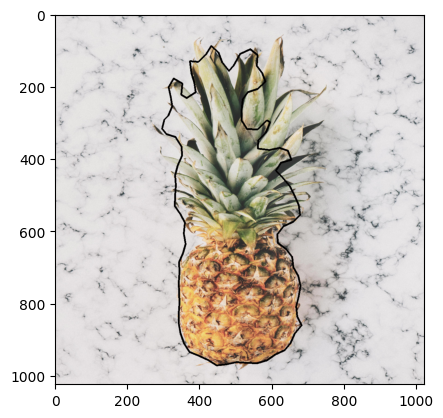

In [196]:
contour_to_display = (np.expand_dims(contours[-1], 1)).astype(int)
new_img = cv2.drawContours(
    (((img / np.max(img)) * 255).astype(np.uint8)).copy(),
    [contour_to_display],
    0,
    color=1,
    thickness=4,
)

plt.imshow(new_img)
plt.show()

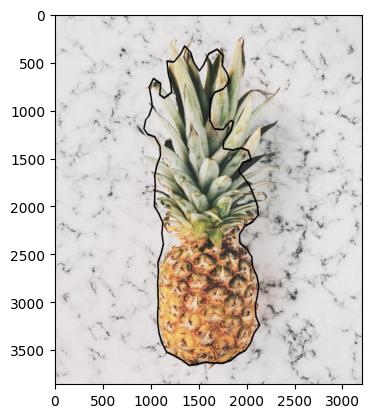

In [197]:
plt.imshow(cv2.resize(new_img, [shape_origin[1], shape_origin[0]]))
plt.show()

In [198]:
import matplotlib

cmap = matplotlib.cm.get_cmap("cool")

colors = [cmap(u)[:-1] for u in np.linspace(0, 1, dac.n_epochs + 1)]
colors = (np.array(colors) * 255).astype(np.int32).tolist()

tots = []
imgs = []

for i, contour in enumerate(contours):
    contour_to_display = (np.expand_dims(contour, 1)).astype(int)

    new_img = cv2.drawContours(
        (((img / np.max(img)) * 255).astype(np.uint8)).copy(),
        [contour_to_display],
        0,
        color=colors[0],
        thickness=4,
    )
    plt.imsave(
        os.path.join("folder_images_paper", filename.split(".")[0] + str(i) +'oriented4' ".png"),
        new_img,
    )

/local/scratch/tmp/ipykernel_878265/1095427.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap("cool")
